# Plynty Bureau of Labor Statistics Consumer Expenditure Analysis

[BLS Comsumer Expenditure Survey](https://www.bls.gov/cex/home.htm)

[Interview Data Dictionary](https://www.bls.gov/cex/2015/csxintvwdata.pdf)

### Where to download the BLS CE PUMD
- The zip files download automatically
- To download the Stub files open the links then right click and choose "Save As..."

[2015 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw15.zip)

[2014 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw14.zip)

[2013 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw13.zip)

[2015 IntStub file](https://www.bls.gov/cex/pumd/2014/csxintstub.txt)

[2015 IStub file](https://www.bls.gov/cex/pumd/2014/csxistub.txt)

[2015 DStub file](https://www.bls.gov/cex/pumd/2014/csxdstub.txt)

### This Scripts Goals for Plynty
- Create an easy to use analysis script for the BLS CE PUMD 
- Create csv files that has average percentages spent on plynty categories for certain income classes
- Compare the Family CUs vs the Single person CUs

#### Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
from copy import deepcopy
from BLSFunctions import *

# Setting Variables

In [2]:
years = ["13","14","15"]
filesToRead = ["fmli", "mtbi"]

minAge = 60
maxAge = 75

familyIncomeBrackets = [-10000000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 160000, 180000, 210000, 240000, 290000, 9980000]
singleIncomeBrackets = [-10000000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 90000, 120000, 9980000]
# familyIncomeBrackets = [-10000000, 20000, 30000, 40000, 50000, 60000, 75000, 90000, 110000, 140000, 200000, 9990000]
# singleIncomeBrackets = [-10000000, 15000, 30000, 40000, 50000, 60000, 75000, 100000, 9990000]

pumdDir = ".../BLS_Python_Analysis/CE_PUMD/"

# Reading in Stubfiles

In [3]:
# Directory where stubfiles are located
pathToStubFileDir = ".../BLS_Python_Analysis/Stubfiles/"
rScriptStubfilePathAndName = ".../BLS_Python_Analysis/creatingStubCsvs.R"

stubFileDict = {}
stubFileDict["IStub"] =  "IStub2015.txt"
stubFileDict["DStub"] =  "DStub2015.txt"
stubFileDict["IntStub"] =  "IntStub2015.txt"

if os.path.isfile(pathToStubFileDir+"DStub.csv") and os.path.isfile(pathToStubFileDir+"IStub.csv") and os.path.isfile(pathToStubFileDir+"IntStub.csv"):
    print("Stubfiles Exist")
else:
    # converting the stub files via R 
    subprocess.call("Rscript "+rScriptStubfilePathAndName+" "+pathToStubFileDir+" "+stubFileDict["IStub"]+" "+stubFileDict["DStub"]+" "+stubFileDict["IntStub"], shell=True)
    print("Stubfile Csvs created in "+pathToStubFileDir)
    
# reading and cleaning the stubfiles    
for key in stubFileDict.keys():
    stubFileDict[key] = pd.read_csv(pathToStubFileDir+key+".csv")
    stubFileDict[key] = stubFileDict[key].drop(stubFileDict[key].columns[0], axis=1)
    stubFileDict[key].loc[stubFileDict[key].level == "*", 'level'] = 0

Stubfiles Exist


# Creating the Data dictionary
output:
   - data (dictionary)
      - key: filenameYear
      - value: dataframe

In [4]:
data = {}
for year in years:
    yearDir = pumdDir+"intrvw"+year+"/intrvw"+year+"/"
    for file in filesToRead:
        print("Reading "+file+year)
        dataframe = readFileSet(file,yearDir)
        data[file+year] = dataframe
        
fmli = pd.concat([value for key,value in data.items() if 'fmli' in key.lower()], ignore_index=True)

Reading fmli13
Reading mtbi13
Reading fmli14
Reading mtbi14
Reading fmli15
Reading mtbi15


# Creating Subset NEWID dictionary
output:
- subsetNEWIDs
 - key: Subset Category
 - value: dictionary or list of NEWIDs associated with the subset

In [5]:
subsetNEWIDs = {}
subsetNEWIDs["Age"] = []
subsetNEWIDs["Family"] = []
subsetNEWIDs["Single"] = []
subsetNEWIDs["Year"] = {}
subsetNEWIDs["Month"] = {}
subsetNEWIDs["FamilyIncome"] = {}
subsetNEWIDs["SingleIncome"] = {}

# creating empty lists within dictionaries
for bracket in range(1,len(familyIncomeBrackets)):
    subsetNEWIDs["FamilyIncome"][bracket] = []
for bracket in range(1,len(singleIncomeBrackets)):
    subsetNEWIDs["SingleIncome"][bracket] = []
for month in range(1,13):
    subsetNEWIDs["Month"][month] = []
for year in years:
    subsetNEWIDs["Year"][2000+int(year)] = []
    
# filling in lists
for year in years:
    fmliYear = "fmli"+year
    subsetNEWIDs["Age"].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName="AGE_REF", minValue=minAge, maxValue=maxAge))
    subsetNEWIDs["Family"].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName="FAM_SIZE", minValue = 2, maxValue = 100))
    subsetNEWIDs["Single"].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName="FAM_SIZE", minValue = 1))
    for year1 in years:
        subsetNEWIDs["Year"][2000+int(year1)].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName = "QINTRVYR", minValue = 2000+int(year1)))
    for month in subsetNEWIDs["Month"].keys():
        subsetNEWIDs["Month"][month].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName = "QINTRVMO",  minValue = month))
    for bracket in subsetNEWIDs["FamilyIncome"].keys():
        subsetNEWIDs["FamilyIncome"][bracket].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName="FINCBTXM",minValue = familyIncomeBrackets[bracket-1], maxValue = familyIncomeBrackets[bracket]-1))
    for bracket in subsetNEWIDs["SingleIncome"].keys():
        subsetNEWIDs["SingleIncome"][bracket].extend(getSubsetNEWIDs(dataframe=data[fmliYear], columnName="FINCBTXM",minValue = singleIncomeBrackets[bracket-1], maxValue = singleIncomeBrackets[bracket]-1))

### Creating Human Readable Income bracket dictionaries

In [6]:
getSingleIncomeBracket = {}
for bracket in subsetNEWIDs["SingleIncome"].keys():
    getSingleIncomeBracket[bracket] = str(singleIncomeBrackets[bracket-1])+"-"+str(singleIncomeBrackets[bracket])

getFamilyIncomeBracket = {}
for bracket in subsetNEWIDs["FamilyIncome"].keys():
    getFamilyIncomeBracket[bracket] = str(familyIncomeBrackets[bracket-1])+"-"+str(familyIncomeBrackets[bracket])

# Subsetting NEWIDs based on SubsetNEWIDs dictionary
outputs:
- Single (dictionary)
 - key: tuple of subset category
 - value: set of NEWIDs assocaiated with tuple
- Family (dictionary)
 - key: tuple of subset category
 - value: set of NEWIDs assocaiated with tuple

In [7]:
Single = subsetDictionary(subsetNEWIDs, ["Age","Single","Year","Month","SingleIncome"])
Family = subsetDictionary(subsetNEWIDs, ["Age","Family","Year","Month","FamilyIncome"])

## Medical Emergencies

In [8]:
allSingleNEWIDs = set()
for newIDset in Single.values():
    allSingleNEWIDs = allSingleNEWIDs.union(newIDset)
allFamilyNEWIDs = set()
for newIDset in Family.values():
    allFamilyNEWIDs = allFamilyNEWIDs.union(newIDset)

allNEWIDs = allFamilyNEWIDs.union(allSingleNEWIDs)

# UCC of Hospital
emergencyUCCs = [570111]

mtbi = pd.concat([value for key,value in data.items() if 'mtbi' in key.lower()], ignore_index=True)
subsetMtbi = mtbi[mtbi.NEWID.isin(allNEWIDs)]
subsetMtbi = subsetMtbi[subsetMtbi.UCC.isin(emergencyUCCs)]
subsetMtbi = subsetMtbi.groupby(['NEWID'],as_index=False).sum()
subsetMtbi = subsetMtbi[subsetMtbi.COST > 300]
oneTimeSubsetMtbi = subsetMtbi[subsetMtbi.REF_YR < 3000]
print("The Hospital expense max value is: "+str(round(oneTimeSubsetMtbi.COST.max(),2)))
print("The Hospital expense mean value is: "+str(round(oneTimeSubsetMtbi.COST.mean(),2)))

The Hospital expense max value is: 7750.0
The Hospital expense mean value is: 1655.31


# Creating Categorical UCC rollups
outputs:
- rollupDict (dictionary)
 - key: Rollup category name
 - value: list of NEWIDs associated with rollup

In [9]:
MonthlyHousing = ["220311","220313","880110","210110","800710","210901","220312","220314","880310","210902","220211","230901","340911","220901","220212","230902","340912","220902","210310"]
# MonthlyHousing = ["220311","220313","880110","210110","800710","210901","220312","220314","880310","210902"]
MonthlyHousing.extend(categoricalUCCRollUp(stubFileDict["IStub"], ["UTILS"]))

rollupDict = {"TotalExp":(categoricalUCCRollUp(stubFileDict["IStub"],["TOTALE"])),
"FoodAtHome":(categoricalUCCRollUp(stubFileDict["IStub"], ["FOODHO", "ALCHOM"])),
"FoodAway":(categoricalUCCRollUp(stubFileDict["IStub"], ["FOODAW", "ALCAWA"])),
"Housing":(["220311","220313","880110","210110","800710","210901","220312","220314","880310","210902"]),
"OtherHousing":(categoricalUCCRollUp(stubFileDict["IStub"], ["HOUSIN"], ignoreUCCs = MonthlyHousing)),
"Utilities":(categoricalUCCRollUp(stubFileDict["IStub"], ["UTILS"])),
"ClothingAndBeauty":(categoricalUCCRollUp(stubFileDict["IStub"], ["APPARE","PERSCA"])),
"Transportation":(categoricalUCCRollUp(stubFileDict["IStub"], ["TRANS"])),
"Healthcare":(categoricalUCCRollUp(stubFileDict["IStub"], ["HEALTH"])),
"Entertainment":(categoricalUCCRollUp(stubFileDict["IStub"], ["ENTRTA","READIN"])),
"Miscellaneous":(categoricalUCCRollUp(stubFileDict["IStub"], ["MISC","TOBACC"])),
"CharitableAndFamilyGiving":(categoricalUCCRollUp(stubFileDict["IStub"], ["CASHCO"])),
"Insurance":(categoricalUCCRollUp(stubFileDict["IStub"], ["LIFEIN"])),
"Education":(categoricalUCCRollUp(stubFileDict["IStub"], ["EDUCAT"])),
"HousingPrinciple":(categoricalUCCRollUp(stubFileDict["IStub"],["MRTPRI"]))}

# converting rollupDict to ints
for key,value in rollupDict.items():
    rollupDict[key] = list(map(int, value))

# Rolling up MTBI files into plynty categories
- creates columns in the mtbi files that correspond with the rollup categories
- fills new rollup columns based on mtbi observations

In [10]:
negativeColumns = ["HousingPrinciple"]
multiple = 1
for dataframe in [key for key in data.keys() if 'mtbi' in key.lower()]:
    for key,value in rollupDict.items():
        if(key in negativeColumns):
            multiple *= -1
        data[dataframe][key] = np.where(data[dataframe].UCC.isin(rollupDict[key]), data[dataframe].COST * multiple, 0)
        multiple = abs(multiple)

#### Cleaning the MTBI dataframes

In [11]:
keepColumns = list(rollupDict.keys())
keepColumns.append("NEWID")

for dataframe in [key for key in data.keys() if 'mtbi' in key.lower()]:
    data[dataframe] = data[dataframe][keepColumns]

# Adding up all the expenses by each NEWID
- Sums for each NEWID
- Adds HousingPrinciple into Housing
- Adds HousingPrinciple into TotalExp
- Drops the HousingPrinciple column

In [12]:
for dataframe in [key for key in data.keys() if 'mtbi' in key.lower()]:
    data[dataframe] = data[dataframe].groupby(['NEWID'],as_index=False).sum()
    data[dataframe]['Housing'] += data[dataframe]['HousingPrinciple']
    data[dataframe]['TotalExp'] += data[dataframe]['HousingPrinciple']
    data[dataframe] = data[dataframe].drop('HousingPrinciple',axis=1)

### Subsetting MTBI files with subset NEWIDs

In [13]:
expensesByNEWIDSingle = expensesSumByNEWID(Single, data)
expensesByNEWIDFamily = expensesSumByNEWID(Family, data)

### Saving the pre-weight expenses by NEWID for the regression

In [14]:
nonWeightedExpensesByNEWIDSingle = deepcopy(expensesByNEWIDSingle)
nonWeightedExpensesByNEWIDFamily = deepcopy(expensesByNEWIDFamily)

## Weighting the Samples

In [15]:
weightSeries = fmli["FINLWT21"]/12
weightSeries.index = fmli["NEWID"]

expensesesByNEWIDSingle = weightExpensesByNEWID(expensesByNEWIDSingle, weightSeries)
expensesByNEWIDFamily = weightExpensesByNEWID(expensesByNEWIDFamily, weightSeries)

## Combining Data frames by Income Class

In [16]:
IncomeClassesSingle = {}
for income in subsetNEWIDs["SingleIncome"]:
    incomeClass = pd.DataFrame()
    for year in subsetNEWIDs["Year"]:
        for month in subsetNEWIDs["Month"]:
            incomeClass = incomeClass.append(expensesByNEWIDSingle[(year,month,income)], ignore_index=True)
    IncomeClassesSingle[income] = incomeClass
    
IncomeClassesFamily = {}
for income in subsetNEWIDs["FamilyIncome"]:
    incomeClass = pd.DataFrame()
    for year in subsetNEWIDs["Year"]:
        for month in subsetNEWIDs["Month"]:
            incomeClass = incomeClass.append(expensesByNEWIDFamily[(year,month,income)], ignore_index=True)
    IncomeClassesFamily[income] = incomeClass

### Sum of all the columns
- Adding up all the columns of a dataframe into totals contained in a dictionary 

In [17]:
plyntySingleSumDict = dictionarySum(IncomeClassesSingle)
plyntyFamilySumDict = dictionarySum(IncomeClassesFamily)

### Creating the Percentage dictionaries

In [18]:
# fixing the TotalExp
for income in plyntySingleSumDict.keys():
    total = 0
    for key,value in plyntySingleSumDict[income].items():
        if not key == 'TotalExp':
            total += value
    plyntySingleSumDict[income]['TotalExp'] = total

for income in plyntyFamilySumDict.keys():
    total = 0
    for key,value in plyntyFamilySumDict[income].items():
        if not key == 'TotalExp':
            total += value
    plyntyFamilySumDict[income]['TotalExp'] = total

In [19]:
plyntySingleDict = incomeSumToPercent(plyntySingleSumDict, "TotalExp")
plyntyFamilyDict = incomeSumToPercent(plyntyFamilySumDict, "TotalExp")

### Deleting the TotalExp Column
This column at this point will be all 1s

In [20]:
for key in plyntySingleDict.keys():
    del plyntySingleDict[key]['TotalExp']
for key in plyntyFamilyDict.keys():
    del plyntyFamilyDict[key]['TotalExp']

# Creating and printing out the plynty Dataframes

In [21]:
plyntySingle = pd.DataFrame.from_dict(plyntySingleDict,orient='index')
plyntyFamily = pd.DataFrame.from_dict(plyntyFamilyDict,orient='index')

In [22]:
plyntySingle

,FoodAtHome,FoodAway,Housing,OtherHousing,Utilities,ClothingAndBeauty,Transportation,Healthcare,Entertainment,Miscellaneous,CharitableAndFamilyGiving,Insurance,Education
1,0.151733,0.043102,0.220826,0.078395,0.116302,0.029350,0.137618,0.097178,0.050136,0.036188,0.034056,0.003955,0.001160
2,0.145579,0.040791,0.196977,0.077551,0.120011,0.024416,0.134384,0.125915,0.060334,0.027070,0.036260,0.006651,0.004061
3,0.123539,0.049394,0.155155,0.109795,0.103588,0.026389,0.153922,0.127650,0.059126,0.028334,0.049319,0.010472,0.003317
4,0.121232,0.054188,0.175342,0.088205,0.104889,0.025048,0.170888,0.112294,0.054290,0.025421,0.051514,0.011575,0.005112
5,0.102517,0.047990,0.164662,0.104533,0.091601,0.028521,0.185000,0.100543,0.055531,0.018793,0.086090,0.009056,0.005164
6,0.101487,0.049018,0.162269,0.107950,0.085412,0.028123,0.189640,0.103850,0.053297,0.021015,0.084958,0.005081,0.007899
7,0.102570,0.057620,0.180263,0.115250,0.092484,0.033225,0.135827,0.114387,0.057565,0.013054,0.085819,0.009256,0.002679
8,0.084397,0.052045,0.158487,0.153268,0.075555,0.033144,0.167354,0.090990,0.068532,0.023191,0.077126,0.006755,0.009154
9,0.072612,0.059808,0.177385,0.111892,0.064484,0.040846,0.193732,0.106236,0.063338,0.027922,0.064419,0.011519,0.005808
10,0.063753,0.069058,0.193303,0.143676,0.058526,0.035682,0.120921,0.077707,0.074606,0.016754,0.109172,0.010156,0.026687


In [23]:
plyntyFamily

,FoodAtHome,FoodAway,Housing,OtherHousing,Utilities,ClothingAndBeauty,Transportation,Healthcare,Entertainment,Miscellaneous,CharitableAndFamilyGiving,Insurance,Education
1,0.148705,0.049024,0.171210,0.078454,0.111228,0.023032,0.150253,0.130573,0.055685,0.030905,0.036855,0.009714,0.004361
2,0.150604,0.046580,0.147371,0.095600,0.114941,0.022229,0.160169,0.129806,0.048030,0.023152,0.050218,0.007737,0.003564
3,0.146657,0.045685,0.129532,0.082477,0.113343,0.022364,0.193720,0.150645,0.042334,0.018517,0.043063,0.008512,0.003151
4,0.136999,0.052827,0.120418,0.089189,0.107676,0.022162,0.182721,0.145500,0.055019,0.019486,0.053396,0.009806,0.004802
5,0.128860,0.053504,0.110143,0.098326,0.102852,0.026415,0.208592,0.138016,0.051442,0.016917,0.046240,0.010928,0.007764
6,0.131199,0.052638,0.122378,0.093215,0.103801,0.024737,0.185199,0.146900,0.059453,0.017564,0.049358,0.009642,0.003917
7,0.119469,0.049687,0.134179,0.097830,0.096224,0.027136,0.203239,0.146259,0.048777,0.016306,0.047379,0.007732,0.005783
8,0.121463,0.056523,0.122102,0.095223,0.094435,0.029977,0.203088,0.133535,0.051273,0.017769,0.051499,0.013260,0.009852
9,0.103535,0.048505,0.128490,0.093911,0.088495,0.026006,0.233608,0.125741,0.065110,0.017966,0.049716,0.010048,0.008870
10,0.108923,0.059231,0.114307,0.108239,0.084319,0.030524,0.210266,0.117719,0.067814,0.019119,0.053729,0.011808,0.014001


# Outputing Dataframes to Csv

In [24]:
# plyntySingle.to_csv("plyntySinglePercentages.csv")
# plyntyFamily.to_csv("plyntyFamilyPercentages.csv")

# Income Spent Regression
### Making Dataframe of NEWID,TotalExp, and income before taxes
outputs:
- incomeRegressionSingle (dataframe)
 - contains NEWID, TotalExp, and IncomeBeforeTaxes for each NEWID in single subset
- incomeRegressionFamily (dataframe)
 - contains NEWID, TotalExp, and IncomeBeforeTaxes for each NEWID in family subset

In [25]:
incomeRegressionSingle = pd.DataFrame()
for value in nonWeightedExpensesByNEWIDSingle.values():
    incomeRegressionSingle = incomeRegressionSingle.append(value[["NEWID","TotalExp"]], ignore_index=True)

incomeRegressionFamily = pd.DataFrame()
for value in nonWeightedExpensesByNEWIDFamily.values():
    incomeRegressionFamily = incomeRegressionFamily.append(value[["NEWID","TotalExp"]], ignore_index=True)

fmli = pd.concat([value for key,value in data.items() if 'fmli' in key.lower()], ignore_index=True)[["NEWID","FINCBTXM"]]    

incomeRegressionSingle = pd.merge(incomeRegressionSingle, fmli, on='NEWID', how='inner')
incomeRegressionSingle['TotalExp'] = incomeRegressionSingle['TotalExp'] * 4
incomeRegressionSingle = incomeRegressionSingle[incomeRegressionSingle > 0].dropna()

incomeRegressionFamily = pd.merge(incomeRegressionFamily, fmli, on='NEWID', how='inner')
incomeRegressionFamily['TotalExp'] = incomeRegressionFamily['TotalExp'] * 4
incomeRegressionFamily = incomeRegressionFamily[incomeRegressionFamily > 0].dropna()

In [26]:
def getExpendPercent(income, regressionDf, truncation = None):
    if income <= 0:
        return(1)
    coefficients = np.polyfit(regressionDf.FINCBTXM, regressionDf.TotalExp, deg = 3)
    p = np.poly1d(coefficients)
#     print(p)
    np.seterr(divide='ignore')
    percent = p(income)/income
    if percent > 1:
        percent = 1
    if (not truncation == None) and len(truncation) == 2:
        truncationIncome = truncation[0]
        truncationPercent = truncation[1]
        if income > truncationIncome:
            return(truncationPercent)
    elif not truncation == None:
        print("Truncation is not correct")
    return(percent)

def oldRegression(income):
    if income > 53000:
        output = ((-7.6108*(10**(-17)))*(income**3))+((4.2009*(10**(-11)))*(income**2))+((-7.90256*(10**-6))*income)+1.21112
    else:
        output = 1
    return(output)

# Plotting

In [27]:
import matplotlib.pyplot as plt

### Creating the Percent of Income Spent Graph

In [28]:
xSingleRegression = range(0,400000,1000)
xFamilyRegression = range(0,400000,1000)
xOldRegression = range(0,350000,1000)
ySingleRegression = []
yFamilyRegression = []
yOldRegression = []
for income in xSingleRegression:
    ySingleRegression.append(getExpendPercent(income, incomeRegressionSingle))
for income in xFamilyRegression:
    yFamilyRegression.append(getExpendPercent(income, incomeRegressionFamily))
for income in xOldRegression:
    yOldRegression.append(oldRegression(income))

### Trucation point for regressions

In [29]:
SingleTruncation = [ySingleRegression.index(min(ySingleRegression)) * 1000, round(min(ySingleRegression),2)]
FamilyTruncation = [yFamilyRegression.index(min(yFamilyRegression)) * 1000, round(min(yFamilyRegression),2)]
ySingleRegression = []
yFamilyRegression = []
for income in xSingleRegression:
    ySingleRegression.append(getExpendPercent(income, incomeRegressionSingle, SingleTruncation))
for income in xFamilyRegression:
    yFamilyRegression.append(getExpendPercent(income, incomeRegressionFamily, FamilyTruncation))

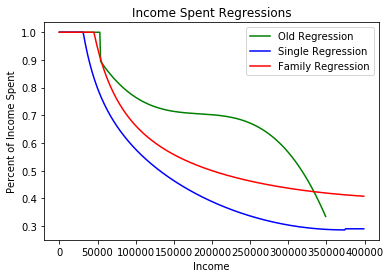

In [30]:
plt.plot(xOldRegression,yOldRegression, color = "g", label = "Old Regression")
plt.plot(xSingleRegression,ySingleRegression, color = "b", label = "Single Regression")
plt.plot(xFamilyRegression,yFamilyRegression, color = "r", label = "Family Regression")
plt.title("Income Spent Regressions")
plt.xlabel("Income")
plt.ylabel("Percent of Income Spent")
plt.legend()
plt.show()

### Number of Users

In [31]:
singleCountNEWIDs = {}
for income in subsetNEWIDs["SingleIncome"]:
    newidSet = set()
    for year in subsetNEWIDs["Year"]:
        for month in subsetNEWIDs["Month"]:
            newidSet = newidSet.union(Single[(year,month,income)])
    singleCountNEWIDs[income] = len(newidSet)
    
familyCountNEWIDs = {}
for income in subsetNEWIDs["FamilyIncome"]:
    newidSet = set()
    for year in subsetNEWIDs["Year"]:
        for month in subsetNEWIDs["Month"]:
            newidSet = newidSet.union(Family[(year,month,income)])
    familyCountNEWIDs[income] = len(newidSet)

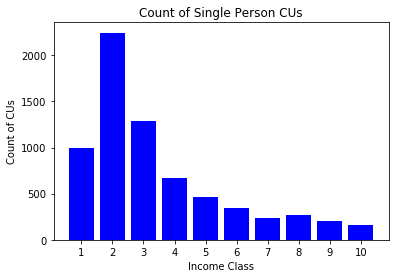

In [32]:
plt.bar(range(len(singleCountNEWIDs)), singleCountNEWIDs.values(), align='center', color='b')
plt.xticks(range(len(singleCountNEWIDs)), singleCountNEWIDs.keys())
plt.xlabel("Income Class")
plt.ylabel("Count of CUs")
plt.title("Count of Single Person CUs")
plt.show()

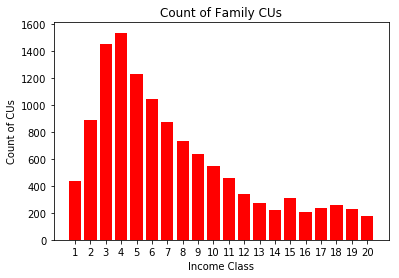

In [33]:
plt.bar(range(len(familyCountNEWIDs)), familyCountNEWIDs.values(), align='center', color='r')
plt.xticks(range(len(familyCountNEWIDs)), familyCountNEWIDs.keys())
plt.xlabel("Income Class")
plt.ylabel("Count of CUs")
plt.title("Count of Family CUs")
plt.show()

# Get Example Expenditures

In [34]:
income = 120000
single = False

if single:
    print("They are single!")
    regressionDf = incomeRegressionSingle
    theIncomeBrackets = singleIncomeBrackets
    plyntyDf = plyntySingle
    truncation = SingleTruncation
else:
    print("It\'s a Family")
    regressionDf = incomeRegressionFamily
    theIncomeBrackets = familyIncomeBrackets
    plyntyDf = plyntyFamily
    truncation = FamilyTruncation

def getIncomeBracketIndex(income, theIncomeBrackets):
    incomebracket = 0
    for i in range(0,len(theIncomeBrackets)):
        if income <= theIncomeBrackets[i]:
            return(i-1)
    return(len(theIncomeBrackets)-1)

round((plyntyDf.iloc[getIncomeBracketIndex(income, theIncomeBrackets),:] * getExpendPercent(income, regressionDf, truncation) * income)/ 12, 2)

It's a Family


FoodAtHome                    612.45
FoodAway                      365.95
Housing                       836.19
OtherHousing                  575.69
Utilities                     472.07
ClothingAndBeauty             192.96
Transportation               1469.87
Healthcare                    654.20
Entertainment                 397.53
Miscellaneous                  83.46
CharitableAndFamilyGiving     331.78
Insurance                      56.38
Education                      68.17
Name: 12, dtype: float64

## Hospital room and services

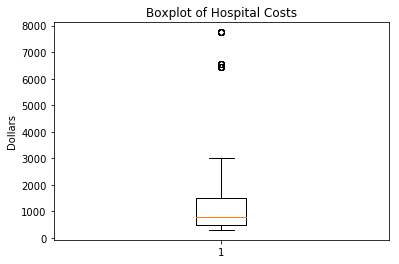

In [35]:
plt.boxplot(list(oneTimeSubsetMtbi.COST))
plt.title("Boxplot of Hospital Costs")
plt.ylabel("Dollars")
plt.show()